# Lineshape (multi-phonon)

This tutorial shows how to obtain the luminescence lineshape, following a multi-phonon mode model.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import phonopy

from pymatgen.io.phonopy import get_pmg_structure
from abipy.abilab import abiopen
from abipy.dfpt.converters import ddb_ucell_to_phonopy_supercell
from abipy.embedding.embedding_ifc import Embedded_phonons
from abipy.lumi.deltaSCF import DeltaSCF
from abipy.core.kpoints import kmesh_from_mpdivs
from abipy.lumi.lineshape import Lineshape

We first load the ab-initio phonons results.
The inputs used to generate these calculations are shown in the next [section](../ifc_emb/lesson_ifc_emb.md).

In [2]:
ddb_pristine = abiopen("../workflows_data/flow_phonons/w0/outdata/out_DDB")

# Phonons of the unit cell bulk, computed on a q-mesh (abinit DDB file)

ph_defect = phonopy.load(supercell_filename="../workflows_data/flow_phonons_doped/w0/outdata/POSCAR",
                         force_sets_filename="../workflows_data/flow_phonons_doped/w0/outdata/FORCE_SETS")

# Phonons obtained with defect supercell of 36 atoms (same than the Delta SCF supercell),
# obtained with finite difference with Phonopy.

Then we create a DeltaSCF object, obtained from the results of a LumiWork workflow.

In [3]:
files = [
    "../workflows_data/flow_deltaSCF/w0/t2/outdata/out_GSR.nc",
    "../workflows_data/flow_deltaSCF/w0/t3/outdata/out_GSR.nc",
    "../workflows_data/flow_deltaSCF/w0/t4/outdata/out_GSR.nc",
    "../workflows_data/flow_deltaSCF/w0/t5/outdata/out_GSR.nc",
]

results = DeltaSCF.from_four_points_file(files)

## Simplest case, no IFCs embedding

We create a lineshape object by combining the $\Delta$SCF and phonons computations.
In this example, the coordinates of the defect are the same in the two supercells used.
It might not be always the case.
This is why these values should be provided explicitly.
Notice that in this first simple example, the phonon supercell size equals the DeltaSCF supercell size,
allowing the use of the displacements or the forces.

In [4]:
# get_pmg_structure(ph_defect.supercell) # to inspect the coords of the defect in phonon scell

lineshape = Lineshape.from_phonopy_phonons(
    E_zpl=results.E_zpl(),
    phonopy_ph=ph_defect,
    dSCF_structure=results.structure_gs(),
    use_forces=False, # we choose the displacements.
    dSCF_displacements=results.diff_pos(),
    dSCF_forces=results.forces_gs,
    coords_defect_dSCF=np.array([3.9795, 0.0000, 1.5920]),
    coords_defect_phonons=np.array([3.9795, 0.0000, 1.5920])
)

help(Lineshape.from_phonopy_phonons)

Mapping between delta SCF supercell and phonon supercell succeeded.  36 / 36
Help on method from_phonopy_phonons in module abipy.lumi.lineshape:

from_phonopy_phonons(E_zpl, phonopy_ph, dSCF_structure, use_forces=True, dSCF_displacements=None, dSCF_forces=None, coords_defect_dSCF=None, coords_defect_phonons=None, tol=0.3) method of builtins.type instance
    Different levels of approximations for the phonons and force/displacements:
    See discussion in the supplementary informations of https://pubs.acs.org/doi/full/10.1021/acs.chemmater.3c00537, section (1).

    - size_supercell deltaSCF = size_supercell phonons (phonons of the bulk structure or phonons of defect structure).
      Use of the forces or the displacemements is allowed.

    - size_supercell dSCF < size_bulk_supercell phonons (bulk)
      Use of the forces only.

    - size_supercell dSCF < size__defect_supercell phonons (embedding)
      Use of the forces only

    The code first extracts the eigenmodes of the phonopy 

From here, we can plot first the Huang-Rhys spectral function $S(\hbar\omega)=S_{\nu}\delta(\hbar\omega-\hbar\omega_{\nu})$,
with an optional colored visualisation of the localisation degree of each mode.

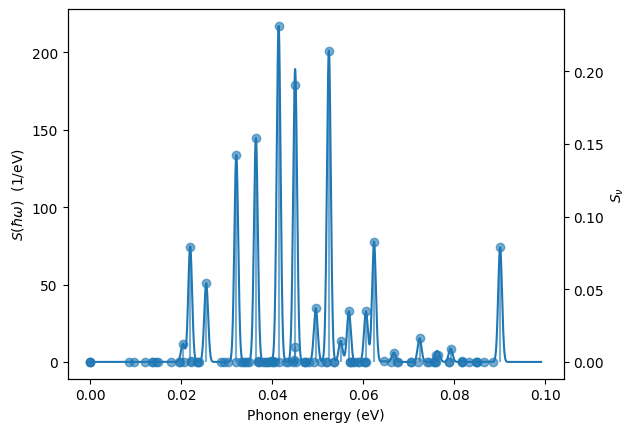

In [5]:
lineshape.plot_spectral_function(with_S_nu=True);

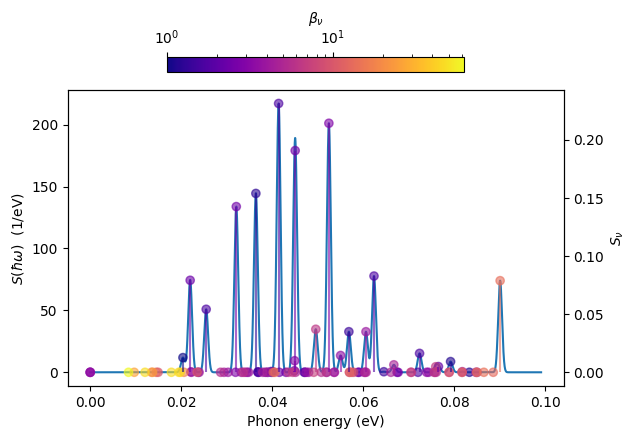

In [6]:
lineshape.plot_spectral_function(with_local_ratio=True);

The total Huang-Rhys factor, computed following the multi phonon mode model, can be compared with the one dimensional model:

In [7]:
print(f"multi phonon Huang-Rhys factor  = {np.round(lineshape.S_tot(),3)}")
print(f"one  phonon Huang-Rhys factor  = {np.round(results.S_em(),3)}")

multi phonon Huang-Rhys factor  = 1.416
one  phonon Huang-Rhys factor  = 1.366


The final luminescence emission spectrum, computed with the generating function approach, can be plotted with at any temperature:

(1.2, 1.8)

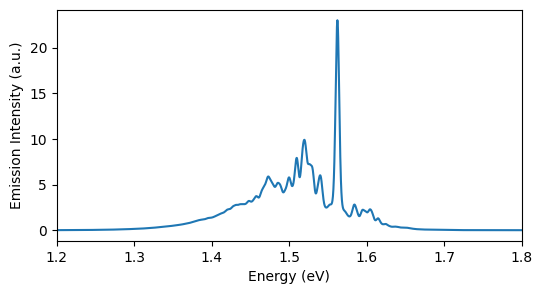

In [8]:
x, y = lineshape.L_hw(T=300, w=5) # w is the width of the gaussian used to smooth the spectrum.
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(x, y)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Emission Intensity (a.u.)")
ax.set_xlim(1.2,1.8)

## With IFCs embedding

We need first to create a phonopy object with embedded IFCs.
See the next tutorial for more details.

This first block of code first interpolates the DDB file on the desired q-mesh (here 2x2x4).
It then performs a folding of these phonons from the unit cell on a 2x2x4 q-mesh to the phonons
on the corresponding 2x2x4 supercell at $\Gamma$ q-point, and save it to phonopy format.

In [9]:
sc_size = [2,2,4]
qpts = kmesh_from_mpdivs(mpdivs=sc_size,shifts=[0,0,0],order="unit_cell")
ddb_pristine_inter = ddb_pristine.anaget_interpolated_ddb(qpt_list=qpts)
ph_pristine = ddb_ucell_to_phonopy_supercell(ddb_pristine_inter)

This block of code prepares the structural information needed for the mapping.

In [10]:
# We need first to create the defect structure without relax

structure_defect_wo_relax = ddb_pristine.structure.copy()
structure_defect_wo_relax.make_supercell([1, 1, 2])
structure_defect_wo_relax.replace(0, 'Eu')

# index of the sub. = 0 (in defect structure), this is found manually
idefect_defect_stru = 0
main_defect_coords_in_defect = structure_defect_wo_relax.cart_coords[idefect_defect_stru]

# index of the sub. = 0 (in pristine structure), this is found manually
from pymatgen.io.phonopy import get_pmg_structure
idefect_pristine_stru=0
main_defect_coords_in_pristine = get_pmg_structure(ph_pristine.supercell).cart_coords[idefect_pristine_stru]

We now call the embbedding algorithm, which creates a phonopy object containing the embedded phonons.

In [11]:
emb_ph = Embedded_phonons.from_phonopy_instances(
    phonopy_pristine=ph_pristine,
    phonopy_defect=ph_defect,
    structure_defect_wo_relax=structure_defect_wo_relax,
    main_defect_coords_in_defect=main_defect_coords_in_defect,
    main_defect_coords_in_pristine=main_defect_coords_in_pristine,
    substitutions_list=[[idefect_pristine_stru,"Eu"]],
    cut_off_mode="auto",verbose=False
)

Number of atoms in the pristine supercell      : 288
Number of atoms in the defective supercell     : 36
Defect infos
    Substitutions:
       0, [4.00242548 0.         1.59996494], Sr1 replaced by Eu
Mapping after structure manipulation           : 36/36



 Set IFC to explicit defect phonons calculations if both atoms are separated from defect by a distance < R_c2 = 3.168



 Enforce ASR

 Embedding procedure done


The lineshape object can be created with these new phonons.

In [12]:
lineshape_emb = Lineshape.from_phonopy_phonons(
    E_zpl=results.E_zpl(),
    phonopy_ph=emb_ph,
    dSCF_structure=results.structure_gs(),
    use_forces=True,
    dSCF_displacements=results.diff_pos(),
    dSCF_forces=results.forces_gs,
    coords_defect_dSCF=np.array([3.9795, 0.0000, 1.5920]),
    coords_defect_phonons=np.array([0,0,0]), # note that the defect coords changed!
)

Mapping between delta SCF supercell and phonon supercell succeeded.  36 / 36


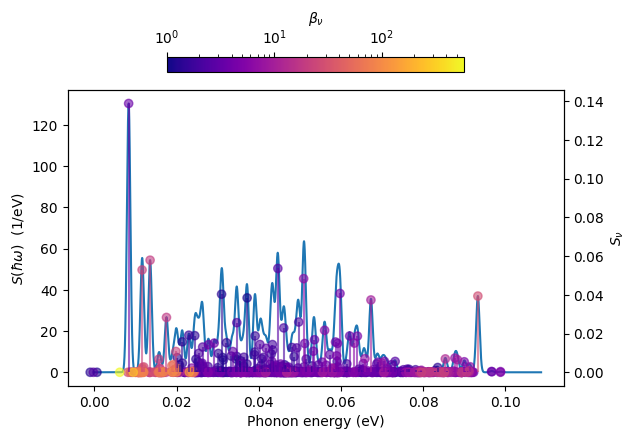

In [13]:
lineshape_emb.plot_spectral_function(with_local_ratio=True);

(1.2, 1.8)

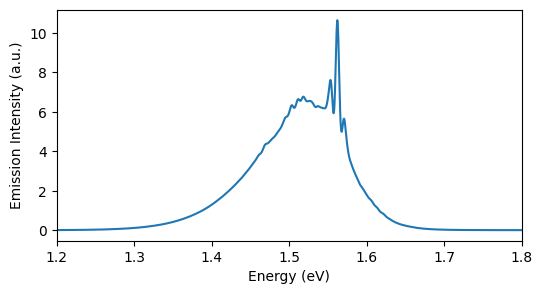

In [14]:
x, y = lineshape_emb.L_hw(T=300, w=5) # w is the width of the gaussian used to smooth the spectrum.
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(x, y)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Emission Intensity (a.u.)")
ax.set_xlim(1.2, 1.8)

Notice how the spectrum broadened because of the increase of the supercell size.
This is because the computed Huang-Rhys factor is larger than the one obtained with the smaller supercell,
and illustrates the importance of converging the supercell size.
The fact that the phonon peaks are less resolved is also due to the increase of the number of phonon modes.
You can also play with the smooting parameter `w` (gaussian) and `lamb` (lorentzian) to see how it affects the spectrum.

In [15]:
print(f"multi phonon Huang-Rhys factor with larger supercell and embedding = {np.round(lineshape_emb.S_tot(),3)}")

multi phonon Huang-Rhys factor with larger supercell and embedding = 1.512


## Convergence with respect to the supercell size

The following block of code illustrates how a convergence study can be performed with respect to the supercell size.
The supercell sizes are defined in the list `sc_sizes`.
The code will loop over these sizes, and compute the lineshape for each of them.
We then plot the Huang-Rhys spectral function for each of the supercell sizes.

In [16]:
sc_sizes=[ [1, 1, 2],
           [2, 2, 2],
           [2, 2, 4],]

lineshape_emb_list = []

structure_defect_wo_relax = ddb_pristine.structure.copy()
structure_defect_wo_relax.make_supercell([1, 1, 2])
structure_defect_wo_relax.replace(0, 'Eu')

# index of the sub. = 0 (in defect structure), this is found manually
idefect_defect_stru = 0
main_defect_coords_in_defect = structure_defect_wo_relax.cart_coords[idefect_defect_stru]

for sc_size in sc_sizes:
    print(f"supercell size: {sc_size}")
    qpts = kmesh_from_mpdivs(mpdivs=sc_size,shifts=[0,0,0],order="unit_cell")
    ddb_pristine_inter = ddb_pristine.anaget_interpolated_ddb(qpt_list=qpts)
    ph_pristine = ddb_ucell_to_phonopy_supercell(ddb_pristine_inter)

    # index of the sub. = 0 (in pristine structure), this is found manually
    from pymatgen.io.phonopy import get_pmg_structure
    idefect_pristine_stru = 0
    main_defect_coords_in_pristine = get_pmg_structure(ph_pristine.supercell).cart_coords[idefect_pristine_stru]

    emb_ph = Embedded_phonons.from_phonopy_instances(
        phonopy_pristine=ph_pristine,
        phonopy_defect=ph_defect,
        structure_defect_wo_relax=structure_defect_wo_relax,
        main_defect_coords_in_defect=main_defect_coords_in_defect,
        main_defect_coords_in_pristine=main_defect_coords_in_pristine,
        substitutions_list=[[idefect_pristine_stru,"Eu"]],
        cut_off_mode="auto",verbose=False
    )

    lineshape_emb = Lineshape.from_phonopy_phonons(
        E_zpl=results.E_zpl(),
        phonopy_ph=emb_ph,
        dSCF_structure=results.structure_gs(),
        use_forces=True,
        dSCF_displacements=results.diff_pos(),
        dSCF_forces=results.forces_gs,
        coords_defect_dSCF=np.array([3.9795, 0.0000, 1.5920]),
        coords_defect_phonons=np.array([0,0,0])) # note that the defect coords changed!

    lineshape_emb_list.append(lineshape_emb)

supercell size: [1, 1, 2]


Number of atoms in the pristine supercell      : 36
Number of atoms in the defective supercell     : 36
Defect infos
    Substitutions:
       0, [4.00242548 0.         1.59996494], Sr1 replaced by Eu
Mapping after structure manipulation           : 36/36

 Set IFC to explicit defect phonons calculations if both atoms are separated from defect by a distance < R_c2 = 3.168

 Enforce ASR

 Embedding procedure done
Mapping between delta SCF supercell and phonon supercell succeeded.  36 / 36
supercell size: [2, 2, 2]


Number of atoms in the pristine supercell      : 144
Number of atoms in the defective supercell     : 36
Defect infos
    Substitutions:
       0, [4.00242548 0.         1.59996494], Sr1 replaced by Eu
Mapping after structure manipulation           : 36/36

 Set IFC to explicit defect phonons calculations if both atoms are separated from defect by a distance < R_c2 = 3.168

 Enforce ASR

 Embedding procedure done


Mapping between delta SCF supercell and phonon supercell succeeded.  36 / 36
supercell size: [2, 2, 4]


Number of atoms in the pristine supercell      : 288
Number of atoms in the defective supercell     : 36
Defect infos
    Substitutions:
       0, [4.00242548 0.         1.59996494], Sr1 replaced by Eu
Mapping after structure manipulation           : 36/36



 Set IFC to explicit defect phonons calculations if both atoms are separated from defect by a distance < R_c2 = 3.168



 Enforce ASR

 Embedding procedure done


Mapping between delta SCF supercell and phonon supercell succeeded.  36 / 36


Text(0, 0.5, '$S(\\hbar\\omega$)')

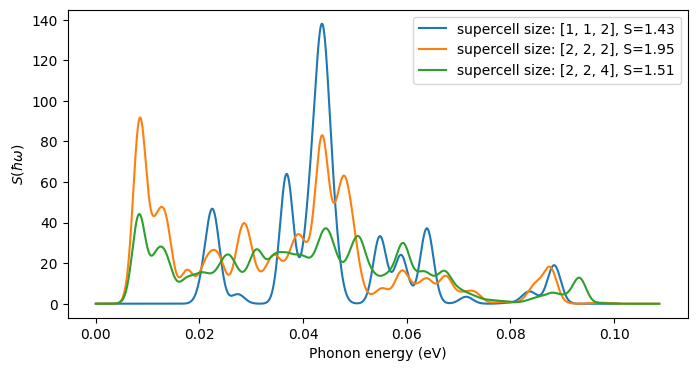

In [17]:
  fig, axs = plt.subplots(figsize=(8,4))

  for i,lineshape in enumerate(lineshape_emb_list):
      x, y = lineshape.S_hbarOmega(broadening=3)
      legend = f"supercell size: {sc_sizes[i]}, S={np.round(lineshape.S_tot(),2)}"
      axs.plot(x, y, label=legend)

  axs.legend()
  axs.set_xlabel("Phonon energy (eV)")
  axs.set_ylabel(r"$S(\hbar\omega$)")

```{note}
For an additional example of the use of this module, you can check the tests examples located in `abipy/lumi/tests/test_lineshape.py`.
```